In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from art.attacks.evasion import ProjectedGradientDescent, BasicIterativeMethod, CarliniL2Method
from art.estimators.classification import TensorFlowV2Classifier


D:\Tarun\Desktop\mlProj\my_venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

In [3]:
# Convert class vectors to binary class matrices (one-hot encoding)
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

In [4]:
def build_model(num_classes):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    return model

In [5]:
# Build and compile model for CIFAR-10
model = build_model(10)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


D:\Tarun\Desktop\mlProj\my_venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [6]:
# Train the model on CIFAR-10
model.fit(x_train, y_train, epochs=10, batch_size=64, validation_data=(x_test, y_test))

Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.3585 - loss: 1.7570 - val_accuracy: 0.5526 - val_loss: 1.2567
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.5781 - loss: 1.1983 - val_accuracy: 0.6110 - val_loss: 1.1088
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.6343 - loss: 1.0487 - val_accuracy: 0.6412 - val_loss: 1.0205
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.6737 - loss: 0.9480 - val_accuracy: 0.6760 - val_loss: 0.9430
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.6929 - loss: 0.8820 - val_accuracy: 0.6666 - val_loss: 0.9760
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.7136 - loss: 0.8300 - val_accuracy: 0.6838 - val_loss: 0.9140
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.7311 - loss: 0.7797 - val_accuracy: 0.6922 - val_loss: 0.8981
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.7410 - loss: 0.7436 - val_accuracy: 

In [7]:
# Create ART classifier
classifier = TensorFlowV2Classifier(model=model, nb_classes=10, input_shape=(32, 32, 3), loss_object=tf.keras.losses.CategoricalCrossentropy())

In [8]:
# PGD Attack
pgd_attack = ProjectedGradientDescent(estimator=classifier, eps=0.1, eps_step=0.01, max_iter=40)
x_test_pgd = pgd_attack.generate(x=x_test)
loss, accuracy = model.evaluate(x_test_pgd, y_test, verbose=0)
print(f"CIFAR-10 PGD Attack Accuracy: {accuracy * 100:.2f}%")

CIFAR-10 PGD Attack Accuracy: 12.80%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0058823526..1.0921569].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.1..1.0529412].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0019607842..1.0882353].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.07647059..1.017647].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.07647059..0.8996078].


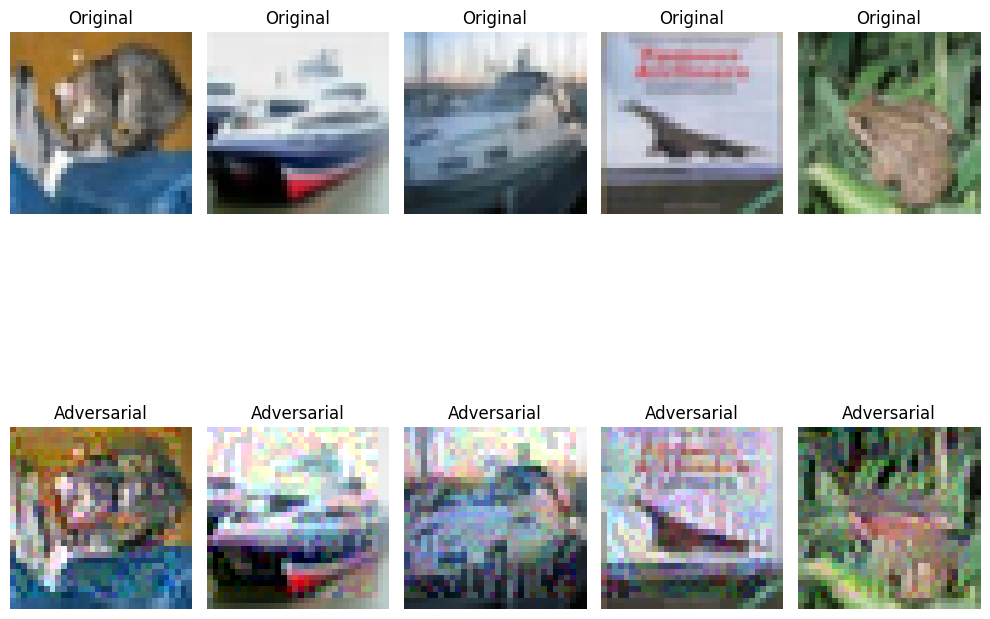

In [9]:
# Visualization
def visualize_examples(x_test, x_adv, num_examples=5):
    plt.figure(figsize=(10, 10))
    for i in range(num_examples):
        plt.subplot(2, num_examples, i + 1)
        plt.imshow(x_test[i])
        plt.title("Original")
        plt.axis('off')
        plt.subplot(2, num_examples, i + 1 + num_examples)
        plt.imshow(x_adv[i])
        plt.title("Adversarial")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Visualize adversarial examples
visualize_examples(x_test, x_test_pgd)